In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## 1.- Analisis exploratorio de datos

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train.shape

(60000, 28, 28)

<function matplotlib.pyplot.show(close=None, block=None)>

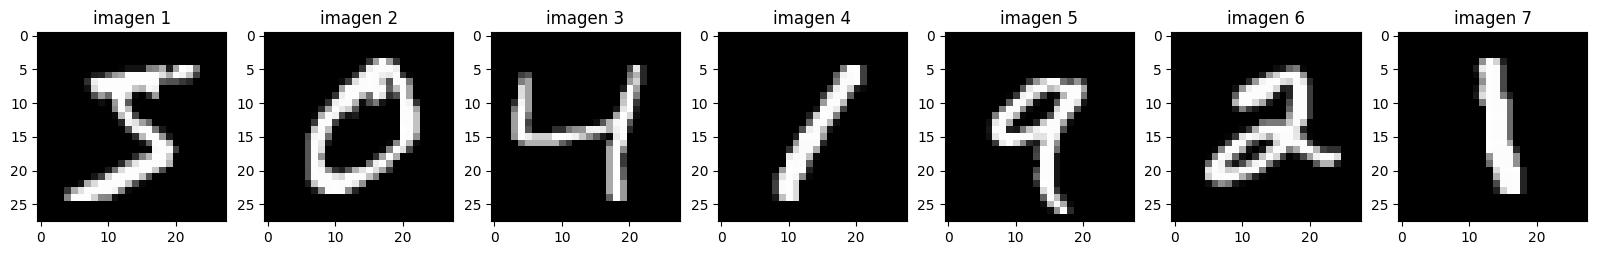

In [4]:
plt.figure(figsize=(20, 4))

for i, imag in enumerate(x_train[0: 7], start=1):
    plt.subplot(1, 7, i)
    plt.imshow(imag, cmap=plt.cm.gray)
    plt.title('imagen ' + str(i))

plt.show

## 2.- Preprocesamiento de datos

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.3, random_state=42)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


## 3.- Definicion de la arquitectura y busqueda de hiperparametros

#### A.- Definimos el espacio de busqueda para el hipertuning

In [7]:
from keras_tuner import Hyperband 

def model_builder(hp):
    model = keras.Sequential()

    model.add(keras.layers.Flatten(input_shape=(28, 28)))

     # espacio de capas y neuronas optimos
    for i in range(hp.Int('num_layers', min_value=1, max_value=5)):
        model.add(keras.layers.Dense(
        units=hp.Int('unit_' + str(i), min_value=32, max_value=160, step=32),
        activation='relu'
    ))

    # capa de salida
    model.add(keras.layers.Dense(10, activation='softmax'))

    # compilacion del modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


#### B.- Configuracion de la busqueda hyperband

In [8]:
from keras_tuner import Hyperband

# crear tuner
tuner = Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='dp_models',
    project_name='hyperband_tuning'
)

c:\Users\jhony\Desktop\DL-Proyects\.conda\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### C.- Iniciamos el hyperband

In [11]:
tuner.search(x_train, y_train,
             epochs=5,
             validation_data=(x_val, y_val),
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"best hiden layers: {best_hps.get('num_layers')}")
print(f"best units: {best_hps.get('unit_0')}")
print(f"best learning rate: {best_hps.get('learning_rate')}")
 

best hiden layers: 3
best units: 128
best learning rate: 0.001


In [17]:
# Construir el mejor modelo con los hiperparámetros obtenidos
best_model = tuner.hypermodel.build(best_hps)

# Compilar el modelo con la métrica 'accuracy'
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),  # Ajusta si tienes otro optimizador
    loss='categorical_crossentropy',  # O ajusta según tu problema (ej., 'categorical_crossentropy' o 'mse')
    metrics=['accuracy']  # Métrica para seguimiento de precisión
)

# Entrenar el modelo
history = best_model.fit(
    x_train, y_train,
    epochs=12,  # Nota: 'epocs' corregido a 'epochs'
    validation_data=(x_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/12
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8745 - loss: 0.4179 - val_accuracy: 0.9603 - val_loss: 0.1235
Epoch 2/12
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9684 - loss: 0.1040 - val_accuracy: 0.9643 - val_loss: 0.1196
Epoch 3/12
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9785 - loss: 0.0686 - val_accuracy: 0.9763 - val_loss: 0.0869
Epoch 4/12
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9827 - loss: 0.0539 - val_accuracy: 0.9740 - val_loss: 0.0852
Epoch 5/12
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9857 - loss: 0.0439 - val_accuracy: 0.9760 - val_loss: 0.0862
Epoch 6/12
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9882 - loss: 0.0357 - val_accuracy: 0.9773 - val_loss: 0.0889
Epoch 7/12
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9900 - loss: 0.0315 - val_accuracy: 0.9740 - val_loss: 0.1005


## 3.- Evaluacion

In [18]:
test_loos, test_acurracy = best_model.evaluate(x_test, y_test)
print(f'acurracy de los datos de prueba {test_acurracy}')

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.9762 - loss: 0.0799
acurracy de los datos de prueba 0.9762856960296631


In [19]:
history = best_model.history
# Graficar precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Curva de precisión')
plt.show()

KeyError: 'accuracy'